#Analyzing Datasets 

##Setup

If the notebook is opened using Google Colab this cell may be used.

Mount google drive to the runtime disk and clone the SYSC4906 repository into google drive. The cell assumes that you have a SYSC4906 folder within your google drive. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/SYSC4906/
!git clone https://github.com/MichaelPatsula/SYSC4906-Project.git
%cd SYSC4906-Project/
!git pull

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/SYSC4906/'
/content
fatal: destination path 'SYSC4906-Project' already exists and is not an empty directory.
/content/SYSC4906-Project
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 11), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (18/18), done.
From https://github.com/MichaelPatsula/SYSC4906-Project
   f505cfa..d8eb4bd  master     -> origin/master
Updating f505cfa..d8eb4bd
Fast-forward
 DataCollection/scrapeNumbeo.ipynb |  142 ---
 Final_Notebook.ipynb              | 2236 ++++++++++++++++++++++++++-----------
 README.md                         |   33 +-
 3 files changed, 1592 insertions(+), 819 deletions(-)
 delete mode 100644 DataCollection/scrapeNumbeo.ipynb


In [2]:
#May be needed to get the most recent plotly dependency
%pip install plotly --upgrade pip

Requirement already up-to-date: plotly in c:\users\christophe\appdata\local\programs\python\python38\lib\site-packages (4.14.3)
  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install adjustText

Using legacy 'setup.py install' for adjustText, since package 'wheel' is not installed.
    Running setup.py install for adjustText: started
    Running setup.py install for adjustText: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


**Step #1**: Initialize dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud, STOPWORDS
from adjustText import adjust_text
import ipywidgets as widgets


**Set to 'colab' if using google colab or set to 'notebook' if using Jupyter notebook**

In [5]:
pio.renderers.default = 'notebook'

In [6]:
reverse_map = {'Abbotsford': 'Abbotsford, BC',
         'Barrie': 'Barrie, ON',
         'Brampton': "Brampton, ON",
         'Burlington': 'Burlington, ON',
         'Burnaby': 'Burnaby, BC',
         'Calgary': 'Calgary, AB',
         'Coquitlam': 'Coquitlam, BC',
         'Edmonton': 'Edmonton, AB',
         'Fredericton': 'Fredericton, NB',
         'Guelph': 'Guelph, ON',
         'Halifax': 'Halifax, NS',
         'Hamilton': 'Hamilton, ON',
         'Kamloops': 'Kamloops, BC',
         'Kelowna': 'Kelowna, BC',
         'Kingston': 'Kingston, ON',
         'Kitchener': 'Kitchener, ON',
         'Langley, BC': 'Langley, BC',
         'Lethbridge, AB': 'Lethbridge, AB',
         'London':'London, ON',
         'Markham': 'Markham ON',
         'Mississauga': 'Mississauga, ON',
         'Moncton': 'Moncton, NB',
         'Montreal': 'Montreal, QC',
         'Nanaimo, BC': 'Nanaimo, BC',
         'New Westminster': 'New Westminster, BC',
         'North Vancouver': 'North Vancouver, BC',
         'Oakville': 'Oakville, ON',
         'Oshawa': 'Oshawa, ON',
         'Ottawa': 'Ottawa, ON',
         'Quebec City': 'Quebec City, QC',
         'Red Deer': 'Red Deer, AB',
         'Regina': 'Regina, SK',
         'Richmond Hill': 'Richmond Hill, ON',
         "Saint John's": "Saint John's, NL",
         'Saskatoon': 'Saskatoon, SK',
         'St.Catharines': 'St.Catharines, ON',
         'Sudbury': 'Sudbury, ON',
         'Surrey': 'Surrey, BC',
         'Thunder Bay': 'Thunder Bay, ON',
         'Toronto': 'Toronto, ON',
         'Vancouver':'Vancouver, BC',
         'Vaughan': 'Vaughan, ON',
         'Victoria': 'Victoria, BC',
         'Waterloo': 'Waterloo, ON',
         'Windsor': 'Windsor, ON',
         'Winnipeg': 'Winnipeg, MB'
}

**Step #2**: Extract data from .csv and into dataframes

In [7]:
jobs = pd.read_csv("DataSet/JobPostDetails/data.csv")
noc_element = pd.read_csv("DataSet/NOC/noc-cnp-2016-element-v4-eng.csv")
noc_structure = pd.read_csv("DataSet/NOC/noc-cnp-2016-structure-v4-eng.csv")
job_levels = pd.read_csv("DataSet/NOC/JobLevels.csv")

#For each file in the Numbeo Data directory insert a list of the data into the numbeo map
numbeo = {}
for dataset in os.listdir("DataSet/Numbeo Data"):
    data = dataset.split(".")[0]
    numbeo[data] = pd.read_csv("DataSet/Numbeo Data/" + dataset)
    numbeo[data].drop("Rank", axis = 1, inplace=True)
    numbeo[data]["City"] = numbeo[data]["City"].apply(lambda x: reverse_map[x])

**Step #3:** Clean the noc_structure and the job_levels dataframe and then marge the two dataframes. 

In [8]:
#Filter the noc_structure to only Unit group and select relevant columns
noc_structure = noc_structure[noc_structure["Hierarchical structure"] == "Unit group"]
noc_structure["Code"] = noc_structure["Code"].astype(np.float64)
noc_structure = noc_structure[["Code", "Class title", "Class definition"]]

#Convert NocNo from job levels to float to merge
job_levels["NocNo"] = job_levels["NocNo"].astype(np.float64)

#Merge the NOC information with jobs
noc_info = pd.merge(noc_structure, job_levels, left_on="Code", right_on="NocNo", how="inner")
noc_info = noc_info.drop("Code", axis=1)

**Step #4:** Clean the job dataframe by filtering to only hour data and taking the average pay wjem available otherwise take the min 

In [9]:
#Clean all jobs to contian only hourly data
jobs_cleaned = jobs.copy(deep=True)
jobs_cleaned = jobs_cleaned[jobs_cleaned["PayUnit"] == "HOUR"]

#Remove some incorrectly labelled hourly data using a heuristic 
jobs_cleaned = jobs_cleaned[~jobs_cleaned["MinPay"].str.contains(',').fillna(False)]
jobs_cleaned = jobs_cleaned[~jobs_cleaned["MaxPay"].str.contains(',').fillna(False)]
jobs_cleaned["MinPay"] = jobs_cleaned["MinPay"].astype(np.float64)
jobs_cleaned["MaxPay"] = jobs_cleaned["MaxPay"].astype(np.float64)

#Get average pay if it exists else use min pay
def get_average_pay(row):
  if np.isnan(row["MaxPay"]):
    return row["MinPay"]
  else:
    return (row["MinPay"] + row["MaxPay"])/2

jobs_cleaned["AveragePay"] = jobs_cleaned.apply(get_average_pay, axis=1)
jobs_cleaned["City"] = jobs_cleaned["City"].str.strip("based in ")

jobs_noc_merged = pd.merge(noc_info, jobs_cleaned, on="NocNo", how="inner")

In [10]:
#These are the numbeo datasets
numbeo.keys()

dict_keys(['CostofLiving', 'Crime', 'HealthCare', 'PropertyPrices', 'Quality of Life', 'Traffic'])

In [11]:
def merge_numbeo_jobs(onDataset):
  return pd.merge(jobs_noc_merged, numbeo[onDataset], on="City", how="inner")

#Visualization methods
def graphScatter(independent_column, dependent_column, title, answer_dataframe, show_points=True, show_line=True, point_column="City", alpha=0.3, figsize=(23, 15)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.set_title(title)
  ax.scatter(answer_dataframe[independent_column], answer_dataframe[dependent_column])
  ax.set_xlabel(independent_column)
  ax.set_ylabel(dependent_column)

  if show_line:
    m, b = np.polyfit(answer_dataframe[independent_column], answer_dataframe[dependent_column], 1)
    ax.plot(answer_dataframe[independent_column], m*answer_dataframe[independent_column]+b, alpha=alpha)


  if show_points:
    annotations = []
    for i, txt in enumerate(answer_dataframe["City"]):
        annotations.append(ax.annotate(txt, (answer_dataframe[independent_column][i], answer_dataframe[dependent_column][i])))
    adjust_text(annotations, only_move={'points':'y', 'texts':'y'})

def graphBar(independent_column, dependent_column, answer_dataframe):
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.bar(answer_dataframe[independent_column], answer_dataframe[dependent_column])
  ax.set_xlabel(independent_column)
  ax.set_ylabel(dependent_column)

def graphMultipleBars(independent_columns, dependent_column, answer_dataframe):
  fig, ax = plt.subplots(figsize=(20, 10))
  
  for index in range(len(independent_columns)):
   ax.bar(answer_dataframe[dependent_column],answer_dataframe[independent_columns[index]])

##Descriptive Statistics

In [12]:
# Descriptive statistics on AveragePay
jobs_noc_merged["AveragePay"].describe()


count    36949.000000
mean        21.612959
std          8.942226
min          0.000000
25%         16.000000
50%         19.180000
75%         25.000000
max        675.000000
Name: AveragePay, dtype: float64

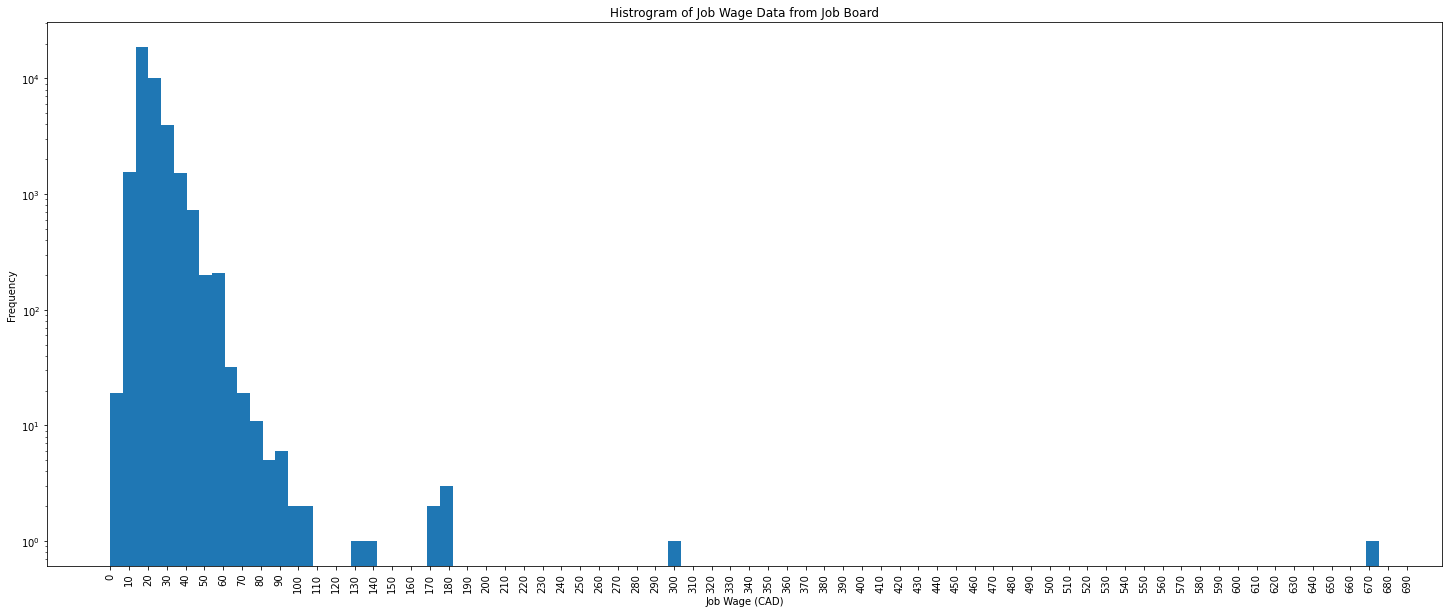

In [13]:
ax = jobs_noc_merged["AveragePay"].plot(logy=True,bins=100,kind="hist",figsize=(25,10), xticks=(np.arange(0,700,step=10)))
plt.setp(ax.get_xticklabels(),rotation = 90)
plt.xlabel("Job Wage (CAD)")
plt.title("Histrogram of Job Wage Data from Job Board")
plt.show()

##Answering Questions

**Is Cost of Living correlated to the Property Prices for a given city?**

In [14]:
method = "spearman"
pd.merge(numbeo["CostofLiving"], numbeo["PropertyPrices"], on="City",  how="inner").corr(method=method)

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Price To Income Ratio,Gross Rental Yield City Centre,Gross Rental Yield Outside of Centre,Price To Rent Ratio City Centre,Price To Rent Ratio Outside Of City Centre,Mortgage As A Percentage Of Income,Affordability Index
Cost of Living Index,1.000000,0.119911,0.367560,0.785095,0.419355,-0.135929,0.111012,-0.191345,-0.087430,0.191991,0.087430,0.127030,-0.124875
Rent Index,0.119911,1.000000,0.946490,-0.061179,0.106563,-0.065184,0.698776,-0.412059,-0.256507,0.412236,0.256507,0.655172,-0.656205
Cost of Living Plus Rent Index,0.367560,0.946490,1.000000,0.119702,0.232506,-0.056514,0.653688,-0.391633,-0.265881,0.392035,0.265881,0.616754,-0.616875
Groceries Index,0.785095,-0.061179,0.119702,1.000000,0.020245,-0.138598,-0.010901,-0.202247,-0.076752,0.200445,0.076752,0.011791,-0.010017
Restaurant Price Index,0.419355,0.106563,0.232506,0.020245,1.000000,-0.085206,0.035818,0.083435,0.084316,-0.082091,-0.084316,0.075417,-0.073011
Local Purchasing Power Index,-0.135929,-0.065184,-0.056514,-0.138598,-0.085206,1.000000,-0.365517,-0.017577,-0.142158,0.015795,0.142158,-0.431368,0.431608
Price To Income Ratio,0.111012,0.698776,0.653688,-0.010901,0.035818,-0.365517,1.000000,-0.754700,-0.658287,0.754839,0.658287,0.987097,-0.986533
Gross Rental Yield City Centre,-0.191345,-0.412059,-0.391633,-0.202247,0.083435,-0.017577,-0.754700,1.000000,0.701969,-0.999889,-0.701969,-0.726888,0.728406
Gross Rental Yield Outside of Centre,-0.087430,-0.256507,-0.265881,-0.076752,0.084316,-0.142158,-0.658287,0.701969,1.000000,-0.701446,-1.000000,-0.627141,0.625487
Price To Rent Ratio City Centre,0.191991,0.412236,0.392035,0.200445,-0.082091,0.015795,0.754839,-0.999889,-0.701446,1.000000,0.701446,0.727253,-0.728770


**Which class titles are hiring the most?** 

In [15]:
#What industry is hiring the most? Top 100
n = 20
jobs_noc_merged["Class title"].value_counts()[:n]

Cooks                                                                       2471
Food service supervisors                                                    2137
Home child care providers                                                   1292
General farm workers                                                        1061
Transport truck drivers                                                     1037
Survey interviewers and statistical clerks                                   971
Administrative assistants                                                    964
Administrative officers                                                      822
Retail sales supervisors                                                     822
Construction trades helpers and labourers                                    813
Home support workers, housekeepers and related occupations                   798
Food counter attendants, kitchen helpers and related support occupations     721
Carpenters                  

The results above show the industries/job types that are currently hiring the most. 
As shown, Cooks, Food service supervisors, Retail salespersons, and truck drivers currently have the most job postings on Canada's Job Bank. 

**How is the affordability index related to the average hiring salary?** 

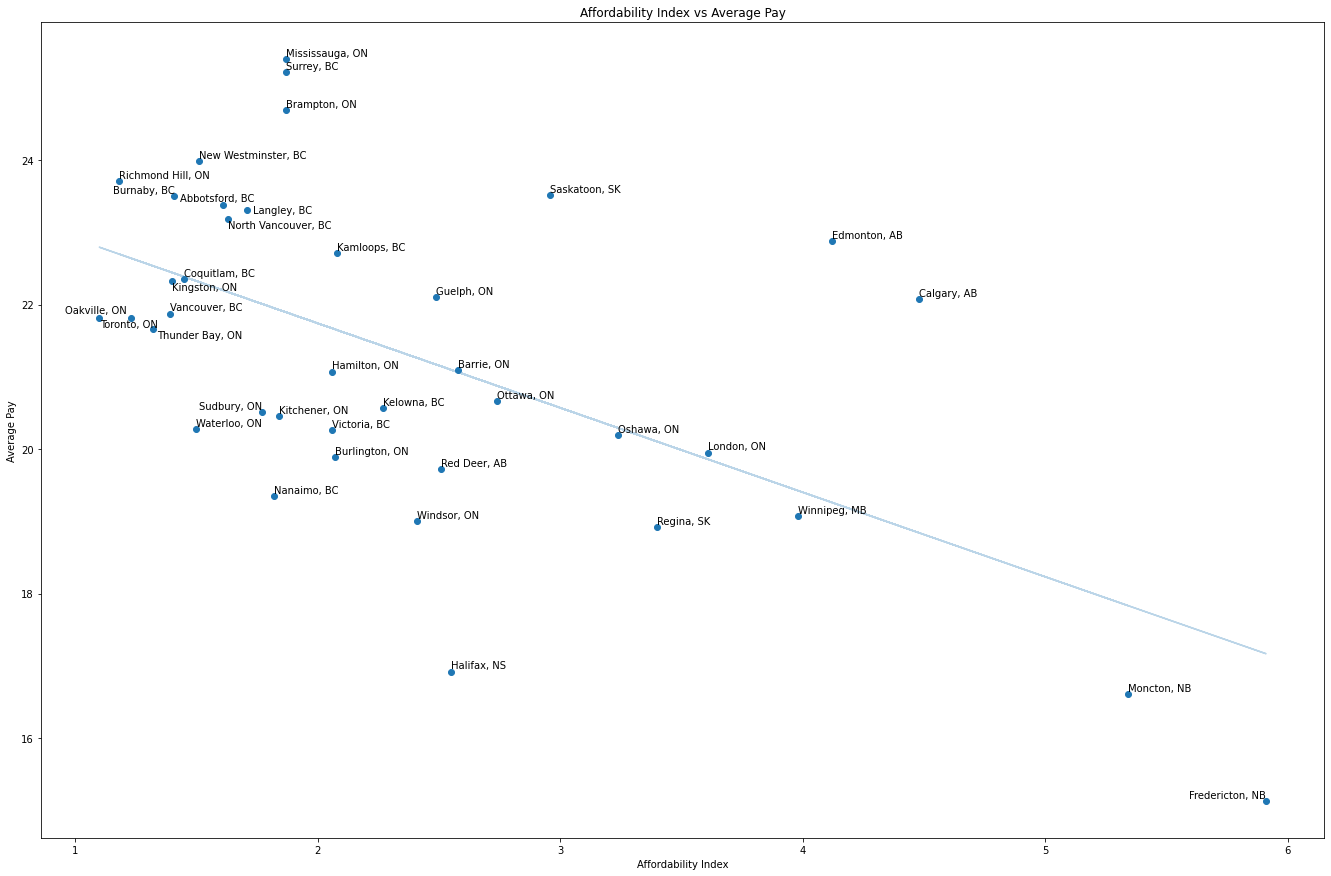

In [16]:
pay_property_merged = merge_numbeo_jobs("PropertyPrices")

#Consider only hourly
pay_property_merged = pay_property_merged[pay_property_merged["PayUnit"] == "HOUR"]

#Create a map of each city and its corresponding average pay.
city_pay = {"City":[], "Average Pay":[]}
for city, group in pay_property_merged.groupby("City"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["MinPay"].mean())
city_pay = pd.DataFrame(city_pay)

#Merge the city_pay dataframe with the PropertyPrices values to get access to the Affordability Index for each city
answer_dataframe = pd.merge(city_pay, numbeo["PropertyPrices"], on="City", how="inner")

#Visualize data with a scatter plot
independent_column = "Affordability Index"
dependent_column = "Average Pay"

graphScatter(independent_column,  dependent_column, "Affordability Index vs Average Pay",  answer_dataframe)

**Interactive visualizer for PropertyPrices**

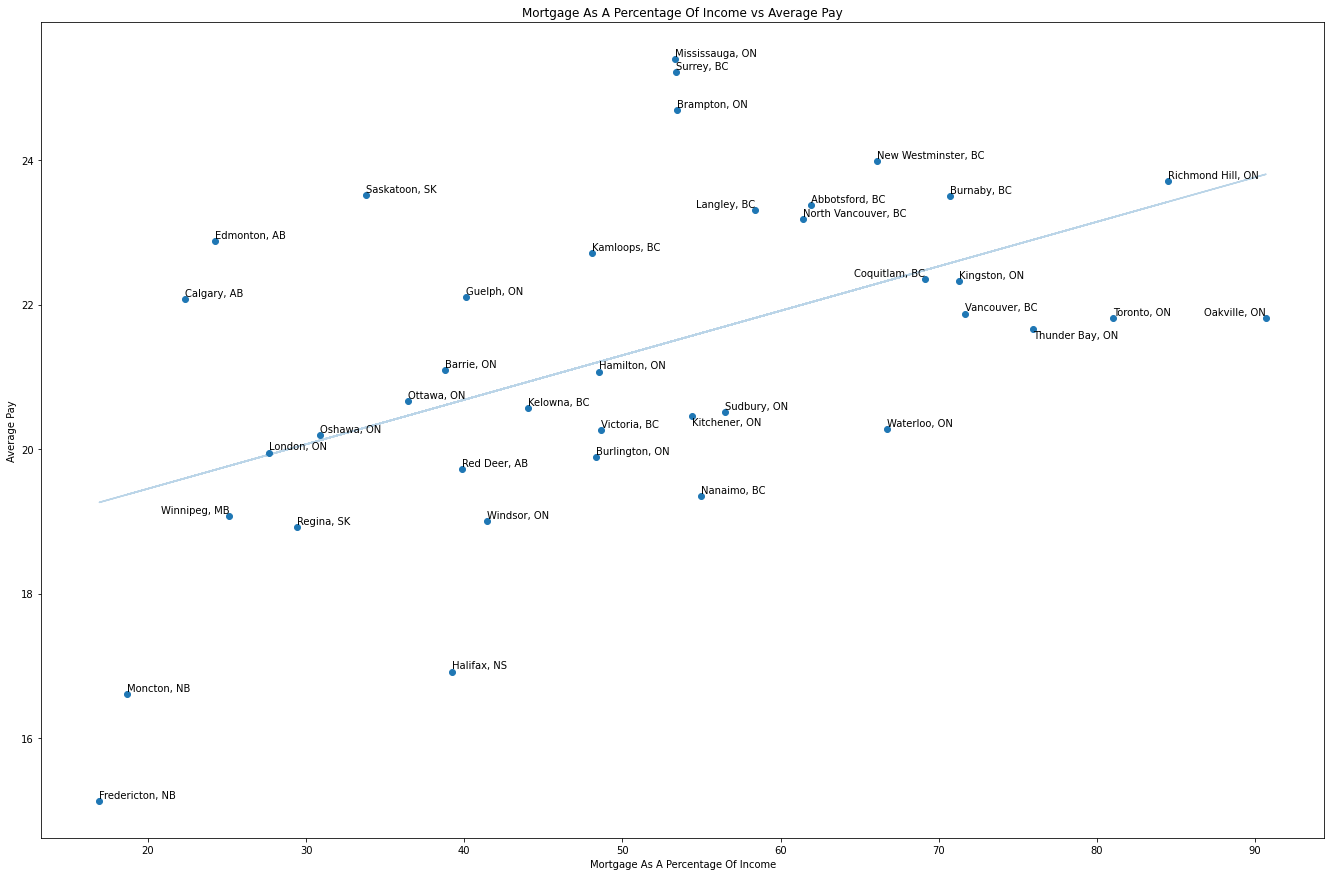

Dropdown(index=6, options=('Price To Income Ratio', 'Gross Rental Yield City Centre', 'Gross Rental Yield Outs…

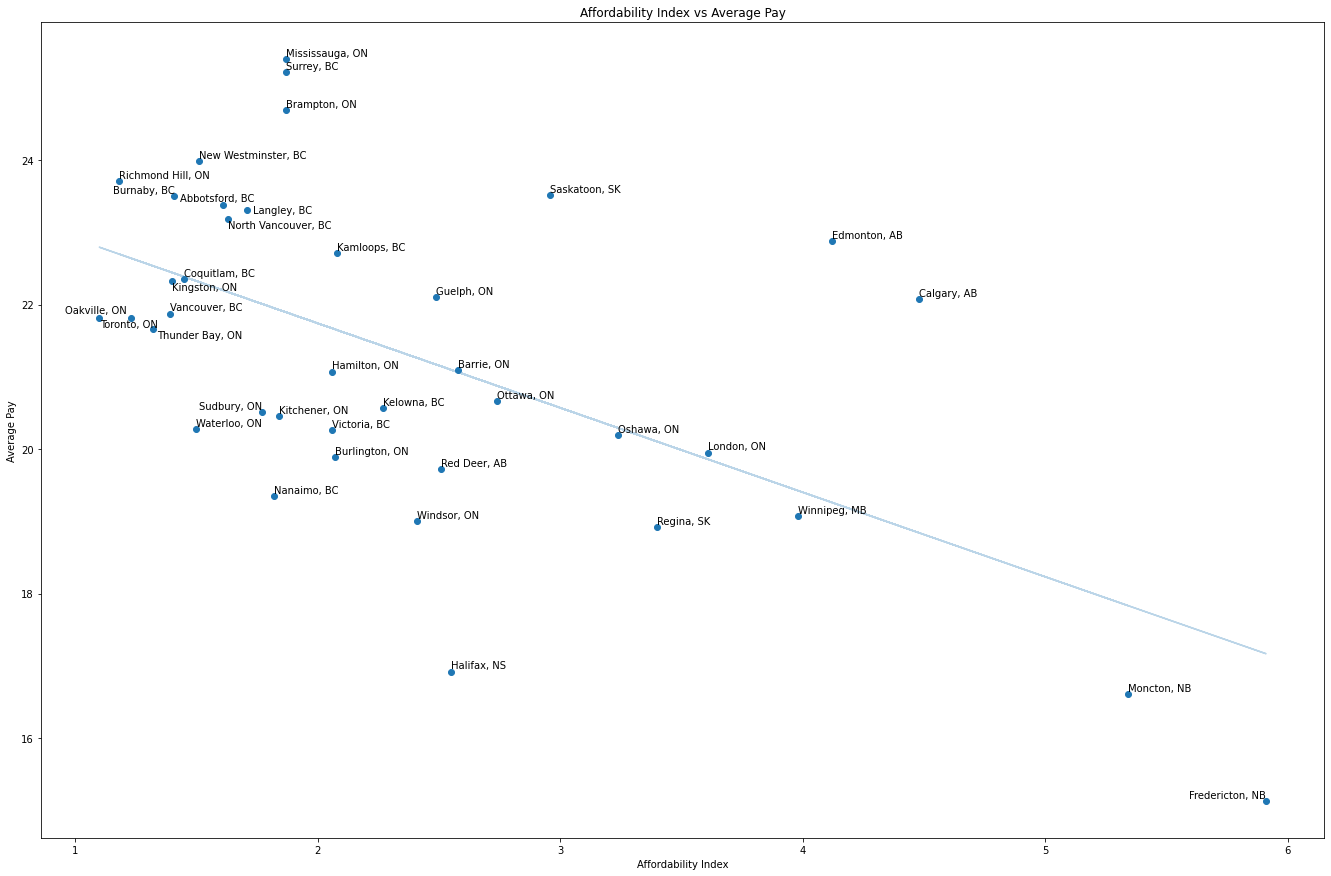

In [24]:
ax = graphScatter('Affordability Index',  dependent_column, f"Affordability Index vs {dependent_column}",  answer_dataframe)
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
      ax = graphScatter(change['new'],  dependent_column, f"{change['new']} vs {dependent_column}",  answer_dataframe)

w = widgets.Dropdown(
    options=['Price To Income Ratio',
       'Gross Rental Yield City Centre',
       'Gross Rental Yield Outside of Centre',
       'Price To Rent Ratio City Centre',
       'Price To Rent Ratio Outside Of City Centre',
       'Mortgage As A Percentage Of Income', 'Affordability Index'],
    value='Affordability Index',
    disabled=False,
)

w.observe(on_dropdown_change)

display(w)

The data shows that there is a correlation between the average pay and the affordability of a property. When the affordability  is low, the average page is generally higher which makes sense. As the affordability index increases (becomes more affordable), the average pay tends to decrease. 

It would seem that Edmonton and Calgary are the ideal locations to work in, given the high affordability index, as well as the average pay being higher than usual.  

**What is the distribution of the number of jobs with respect to their job levels across provinces?**

In [25]:
#Strip the JobLevel column of extra whitespaces and insert the result into 
#the cleanedJobLevel array
cleanedJobLevel = []
df = jobs_noc_merged.copy(deep=True)
for x in df['JobLevel']:
  cleanedJobLevel.append(x.strip())
df['CleanedJobLevel'] = cleanedJobLevel

#Replace the City column with a Province column
df["City"] = df["City"].apply(lambda x: x.split(',')[1])
df = df.rename(columns={'City': 'Province'})

#Find the number of Level A jobs for each province and store the result in the city_levelA dictionary. 
city_levelA = {"Province":[], "Level A":[]}
grouped = df.query("CleanedJobLevel == 'A'").groupby("Province")
for province, group in grouped:
  city_levelA['Province'].append(province)
  city_levelA['Level A'].append(group.count()[1])
city_levelA = pd.DataFrame(city_levelA)

#Find the number of Level B jobs for each province and store the result in the city_levelB dictionary. 
city_levelB = {"Province":[], "Level B":[]}
grouped = df.query("CleanedJobLevel == 'B'").groupby("Province")
for province, group in grouped:
  city_levelB['Province'].append(province)
  city_levelB['Level B'].append(group.count()[1])
city_levelB = pd.DataFrame(city_levelB)

#Find the number of Level C jobs for each province and store the result in the city_levelC dictionary. 
city_levelC = {"Province":[], "Level C":[]}
grouped = df.query("CleanedJobLevel == 'C'").groupby("Province")
for province, group in grouped:
  city_levelC['Province'].append(province)
  city_levelC['Level C'].append(group.count()[1])
city_levelC = pd.DataFrame(city_levelC)

#Find the number of Level D jobs for each province and store the result in the city_levelD dictionary. 
city_levelD = {"Province":[], "Level D":[]}
grouped = df.query("CleanedJobLevel == 'D'").groupby("Province")
for province, group in grouped:
  city_levelD['Province'].append(province)
  city_levelD['Level D'].append(group.count()[1])
city_levelD = pd.DataFrame(city_levelD)

#Find the number of Level 0 jobs for each province and store the result in the city_level0 dictionary. 
city_level0 = {"Province":[], "Level 0":[]}
grouped = df.query("CleanedJobLevel == '0'").groupby("Province")
for province, group in grouped:
  city_level0['Province'].append(province)
  city_level0['Level 0'].append(group.count()[1])
city_level0 = pd.DataFrame(city_level0)

Text(0.5, 1.0, 'The Distribution of Job Skill Level on Job Board Across Canadian Provinces')

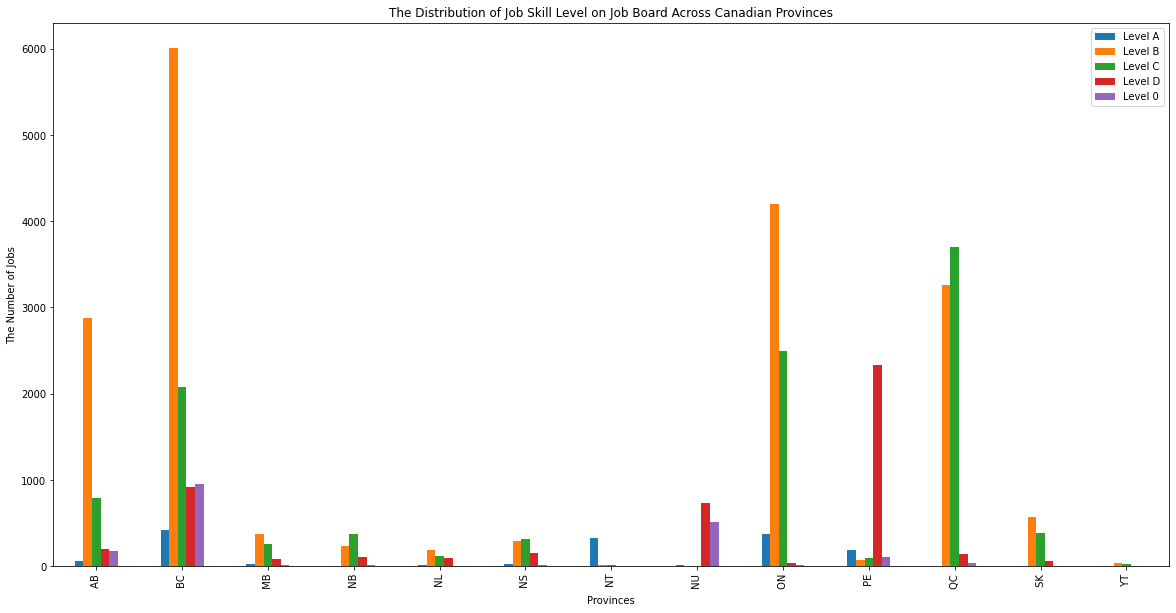

In [26]:
#Visualize the number of each level of jobs is within the job board for each Canadian province. 
result = pd.concat([city_level0, city_levelD, city_levelB, city_levelA], axis=1)
result.drop(result.columns[2], axis=1, inplace=True)
result = pd.concat([city_levelC, result], axis=1)
result = result.fillna(0)
ax = result.plot(x="Province", y=["Level A", "Level B", "Level C","Level D","Level 0"], kind="bar",figsize=(20,10))
ax.set_xlabel("Provinces")
ax.set_ylabel("The Number of Jobs")
ax.set_title("The Distribution of Job Skill Level on Job Board Across Canadian Provinces")

**What provinces has the highest paying jobs per hour?**


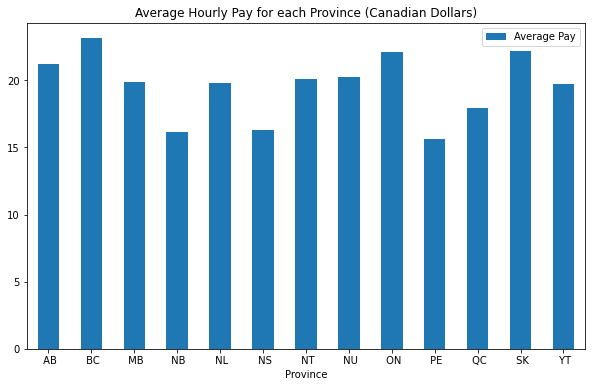

In [27]:
#Consider only hourly pay
jobs_paid_hourly_cleaned = jobs_noc_merged.copy(deep=True)

#Change city to province
jobs_paid_hourly_cleaned["Province"] = jobs_paid_hourly_cleaned["City"].apply(lambda x: x.split(',')[1])

province_pay = {"Province":[], "Average Pay":[]}
for province, group in jobs_paid_hourly_cleaned.groupby("Province"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    province_pay["Province"].append(province)
    province_pay["Average Pay"].append(group["MinPay"].mean())
province_pay = pd.DataFrame(province_pay)

independent_column = "Province"
dependent_column = "Average Pay"

#Visualize
ax = province_pay.plot(x='Province',
                       y='Average Pay',
                       kind="bar",
                       rot=0,          #rot is for rotation of labels 
                       figsize=(10,6),
                       title="Average Hourly Pay for each Province (Canadian Dollars)") 

**What is the distribution of the average salary of jobs with respect to their job levels across provinces?**

In [28]:
#Strip the JobLevel column of extra whitespaces and insert the result into 
#the cleanedJobLevel array
cleanedJobLevel = []
df = jobs_noc_merged.copy(deep=True)
for x in df['JobLevel']:
  cleanedJobLevel.append(x.strip())
df['CleanedJobLevel'] = cleanedJobLevel

#Replace the City column with a Province column
df["City"] = df["City"].apply(lambda x: x.split(',')[1])
df = df.rename(columns={'City': 'Province'})

#Find the average salary of Level A jobs for each province and store the result in the city_levelA dictionary. 
city_levelA = {"Province":[], "Level A":[]}
grouped = df.query("CleanedJobLevel == 'A'").groupby("Province")
for province, group in grouped:
  city_levelA['Province'].append(province)
  city_levelA['Level A'].append(group["AveragePay"].mean())
city_levelA = pd.DataFrame(city_levelA)

#Find the number of Level B jobs for each province and store the result in the city_levelB dictionary. 
city_levelB = {"Province":[], "Level B":[]}
grouped = df.query("CleanedJobLevel == 'B'").groupby("Province")
for province, group in grouped:
  city_levelB['Province'].append(province)
  city_levelB['Level B'].append(group["AveragePay"].mean())
city_levelB = pd.DataFrame(city_levelB)

#Find the number of Level C jobs for each province and store the result in the city_levelC dictionary. 
city_levelC = {"Province":[], "Level C":[]}
grouped = df.query("CleanedJobLevel == 'C'").groupby("Province")
for province, group in grouped:
  city_levelC['Province'].append(province)
  city_levelC['Level C'].append(group["AveragePay"].mean())
city_levelC = pd.DataFrame(city_levelC)

#Find the number of Level D jobs for each province and store the result in the city_levelD dictionary. 
city_levelD = {"Province":[], "Level D":[]}
grouped = df.query("CleanedJobLevel == 'D'").groupby("Province")
for province, group in grouped:
  city_levelD['Province'].append(province)
  city_levelD['Level D'].append(group["AveragePay"].mean())
city_levelD = pd.DataFrame(city_levelD)

#Find the number of Level 0 jobs for each province and store the result in the city_level0 dictionary. 
city_level0 = {"Province":[], "Level 0":[]}
grouped = df.query("CleanedJobLevel == '0'").groupby("Province")
for province, group in grouped:
  city_level0['Province'].append(province)
  city_level0['Level 0'].append(group["AveragePay"].mean())
city_level0 = pd.DataFrame(city_level0)

Text(0.5, 1.0, 'The Distribution of Job Skill Level Salary on Job Board Across Canadian Provinces')

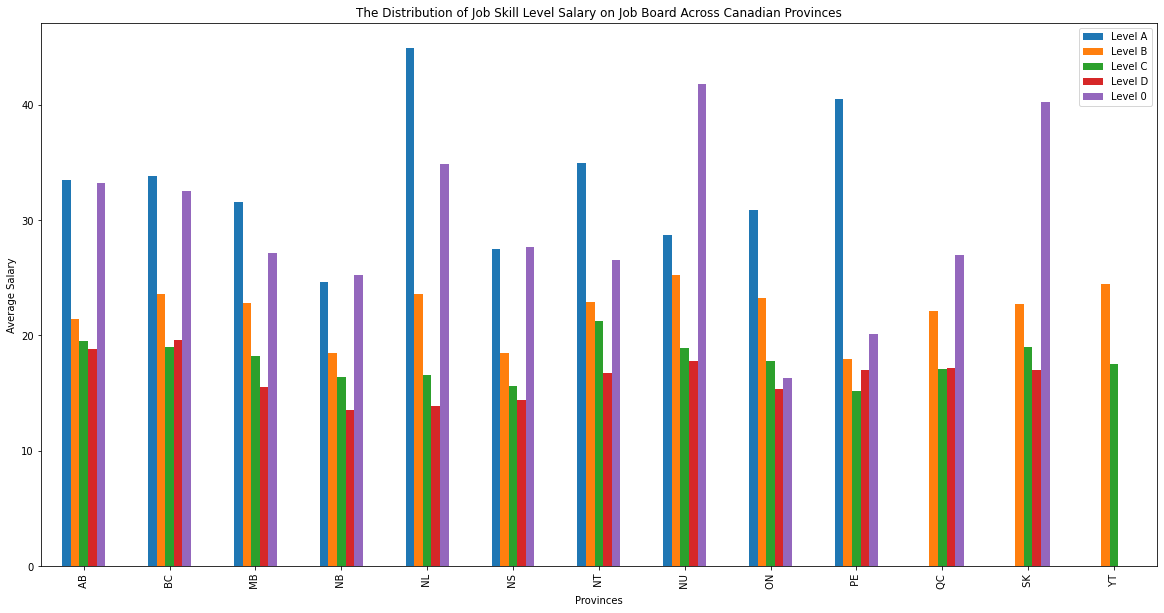

In [29]:
#Visualize the number of each level of jobs is within the job board for each Canadian province. 
result = pd.concat([city_level0, city_levelD, city_levelB, city_levelA], axis=1)
result.drop(result.columns[2], axis=1, inplace=True)
result = pd.concat([city_levelC, result], axis=1)
result = result.fillna(0)
ax = result.plot(x="Province", y=["Level A", "Level B", "Level C","Level D","Level 0"], kind="bar",figsize=(20,10))
ax.set_xlabel("Provinces")
ax.set_ylabel("Average Salary")
ax.set_title("The Distribution of Job Skill Level Salary on Job Board Across Canadian Provinces")

**Interactive visualization for quality of life**
The below code aggregates the average pay for each province with the quality of life data from Numbeo to create a choropleth map of Canada. When hovering over the provinces of Canada a pop-up box will be displayed containing the quality of life statstics for the respective province, its computed average pay and the number of jobs found within the job board for the province. 

In [47]:
canada = json.load(open("DataSet/Canada/canada_provinces.geojson", "r"))

province_reverse_map = {'Abbotsford': 'Abbotsford, BC',
         'Newfoundland and Labrador': 'NL',
         'Prince Edward Island': 'PE',
         'Nova Scotia': 'NS',
         'New Brunswick': 'NB',
         'Quebec': 'QC',
         'Ontario': 'ON',
         'Manitoba': 'MB',
         'Saskatchewan': 'SK',
         'Alberta': 'AB',
         'British Columbia': 'BC',
         'Yukon': 'YT',
         'Northwest Territories': 'NT',
         'Nunavut': 'NU'
}

#Clean and preprocess data
df = jobs_noc_merged.copy(deep=True)
numbeo_key = "Quality of Life"
quality_of_life_merged = pd.merge(df, numbeo[numbeo_key], on="City", how="left")
quality_of_life_merged["Province"] = quality_of_life_merged["City"].apply(lambda x: x.split(',')[1].strip())

summary_stats = {"Province":[],
                 "Average Pay":[],
                 "Quality of Life Index":[],
                 'Purchasing Power Index':[],
                 'Health Care Index':[],
                 'Cost of Living Index':[],
                 'Property Price to Income Ratio':[],
                 'Traffic Commute Time Index':[],
                 'Pollution Index':[],
                 'Climate Index':[],
                 'Number of Jobs':[]
                }

#Create dictionary containing the mean values of the KPIs in the summary_stats dict
for province, group in quality_of_life_merged.groupby("Province"):
    summary_stats["Province"].append(province)
    summary_stats["Average Pay"].append(group["AveragePay"].mean())
    summary_stats['Quality of Life Index'].append(group['Quality of Life Index'].mean())
    summary_stats['Purchasing Power Index'].append(group['Purchasing Power Index'].mean())
    summary_stats['Health Care Index'].append(group['Health Care Index'].mean())
    summary_stats['Cost of Living Index'].append(group['Cost of Living Index'].mean())
    summary_stats['Property Price to Income Ratio'].append(group['Property Price to Income Ratio'].mean())
    summary_stats['Traffic Commute Time Index'].append(group['Traffic Commute Time Index'].mean())
    summary_stats['Climate Index'].append(group['Climate Index'].mean())
    summary_stats['Pollution Index'].append(group['Pollution Index'].mean())
summary_stats['Number of Jobs'] = quality_of_life_merged.groupby('Province').count()['AveragePay'].tolist()

summary_stats = pd.DataFrame(summary_stats)

#From the canada dataset extract an id and province name for each province and insert it into a dict
provience_id_map_before = {}
for feature in canada['features']:
  feature['id'] = feature['properties']['cartodb_id']
  provience_id_map_before[feature['properties']['name']] = feature['id']

#Replace the province name in the provience_id_map_before dict with the abbreviated province name
provience_id_map = {}
for province, abbrev in provience_id_map_before.items():
  provience_id_map[province_reverse_map[province]] = provience_id_map_before[province]

#Add each key as a column in the summary_Stats dataframe
summary_stats['Province'] = summary_stats['Province'].str.strip()
summary_stats["id"] = summary_stats["Province"].apply(lambda x: provience_id_map[x])
summary_stats.fillna("None", inplace = True)

#Create choropleth graph of canada
fig = px.choropleth(
    summary_stats,
    locations="id",
    geojson=canada,
    color="Average Pay",
    hover_name="Province",
    hover_data=['Quality of Life Index','Purchasing Power Index',
                'Health Care Index','Cost of Living Index',
                'Property Price to Income Ratio',
                'Traffic Commute Time Index',
                'Climate Index',
                'Pollution Index',
                'Number of Jobs'],
    title="The Average Pay Per Hour Across Canadian Provinces",
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

summary_stats

,Province,Average Pay,Quality of Life Index,Purchasing Power Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,Number of Jobs,id
0,AB,21.587746,171.554,108.374,77.7537,72.537,3.59037,29.7988,27.2676,32.4996,4117,4
1,BC,23.553591,176.881,91.2754,74.5777,72.3703,9.80718,34.7819,22.4157,87.1182,10369,6
2,MB,20.843783,142.94,92.76,69.06,70.49,3.76,31.47,37.46,24.67,752,10
3,NB,16.889851,None,None,None,None,None,None,None,None,738,7
4,NL,20.509207,None,None,None,None,None,None,None,None,429,5
5,NS,17.039583,166.08,81.83,70.23,74.48,5.7,30.8,23.12,58.99,803,2
6,NT,21.540250,None,None,None,None,None,None,None,None,40,13
7,NU,21.422000,None,None,None,None,None,None,None,None,5,12
8,ON,22.743783,157.631,86.7795,73.1252,72.3011,8.6638,38.9969,30.2905,58.9465,8270,11
9,PE,16.657547,None,None,None,None,None,None,None,None,214,8


**How is the quality of life index related to the average hiring salary?**


In [31]:
numbeo_key = "Quality of Life"
quality_of_life_merged = pd.merge(jobs_noc_merged, numbeo[numbeo_key], on="City", how="inner")

#Compute the average pay for each city and store it inside the city_pay map
city_pay = {"City":[], "Average Pay":[]}
for city, group in quality_of_life_merged.groupby("City"):
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["AveragePay"].mean())
city_pay = pd.DataFrame(city_pay)

#Join the city_pay dictionary with the numbeo Quality of Life dataset
qol_answer_dataframe = pd.merge(city_pay, numbeo[numbeo_key], on="City", how="inner")

independent_column = "Quality of Life Index"
dependent_column = "Average Pay"

#Correlation
method = "spearman"
qol_answer_dataframe.corr(method=method)

,Average Pay,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
Average Pay,1.000000,0.279720,0.321678,0.328671,0.524476,0.153846,0.118881,0.440559,0.097902,0.062937
Quality of Life Index,0.279720,1.000000,0.447552,0.818182,0.090909,0.482517,-0.097902,-0.314685,-0.783217,0.223776
Purchasing Power Index,0.321678,0.447552,1.000000,0.181818,-0.041958,0.181818,-0.510490,-0.258741,0.048951,-0.482517
Safety Index,0.328671,0.818182,0.181818,1.000000,0.188811,0.699301,0.139860,0.048951,-0.650350,0.356643
Health Care Index,0.524476,0.090909,-0.041958,0.188811,1.000000,0.139860,0.034965,0.209790,0.181818,0.342657
Cost of Living Index,0.153846,0.482517,0.181818,0.699301,0.139860,1.000000,0.265734,0.335664,-0.188811,0.363636
Property Price to Income Ratio,0.118881,-0.097902,-0.510490,0.139860,0.034965,0.265734,1.000000,0.559441,0.055944,0.818182
Traffic Commute Time Index,0.440559,-0.314685,-0.258741,0.048951,0.209790,0.335664,0.559441,1.000000,0.454545,0.307692
Pollution Index,0.097902,-0.783217,0.048951,-0.650350,0.181818,-0.188811,0.055944,0.454545,1.000000,-0.237762
Climate Index,0.062937,0.223776,-0.482517,0.356643,0.342657,0.363636,0.818182,0.307692,-0.237762,1.000000


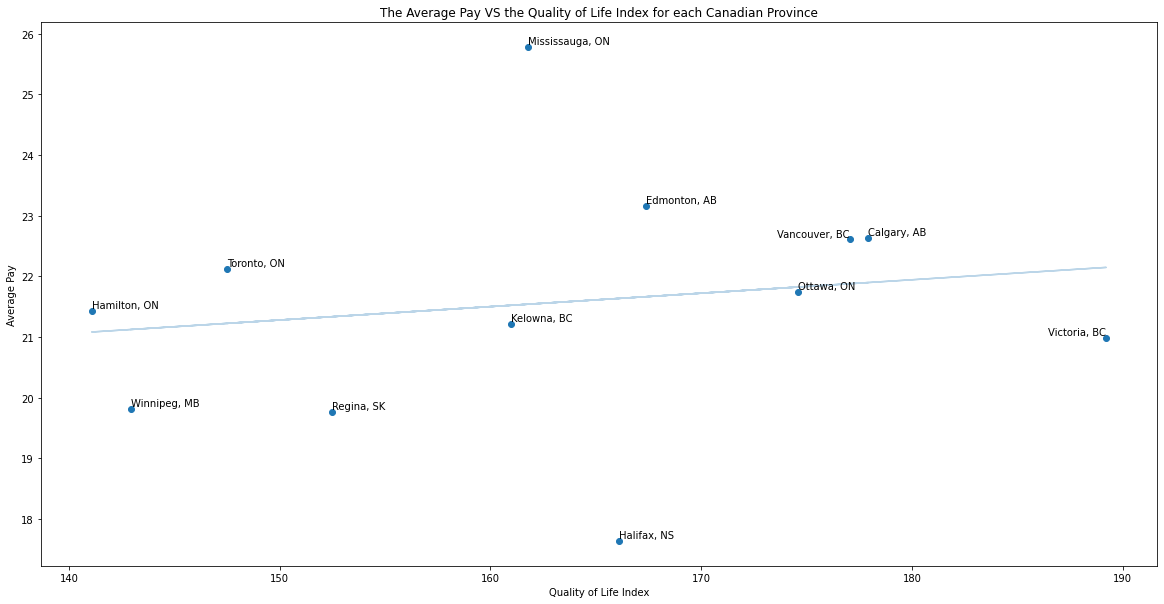

In [32]:
#Visualize
graphScatter(independent_column,  dependent_column, "The Average Pay VS the Quality of Life Index for each Canadian Province", qol_answer_dataframe, figsize=(20, 10))

**Interactive visualization for quality of life**

Dropdown(options=('Quality of Life Index', 'Purchasing Power Index', 'Safety Index', 'Health Care Index', 'Cos…

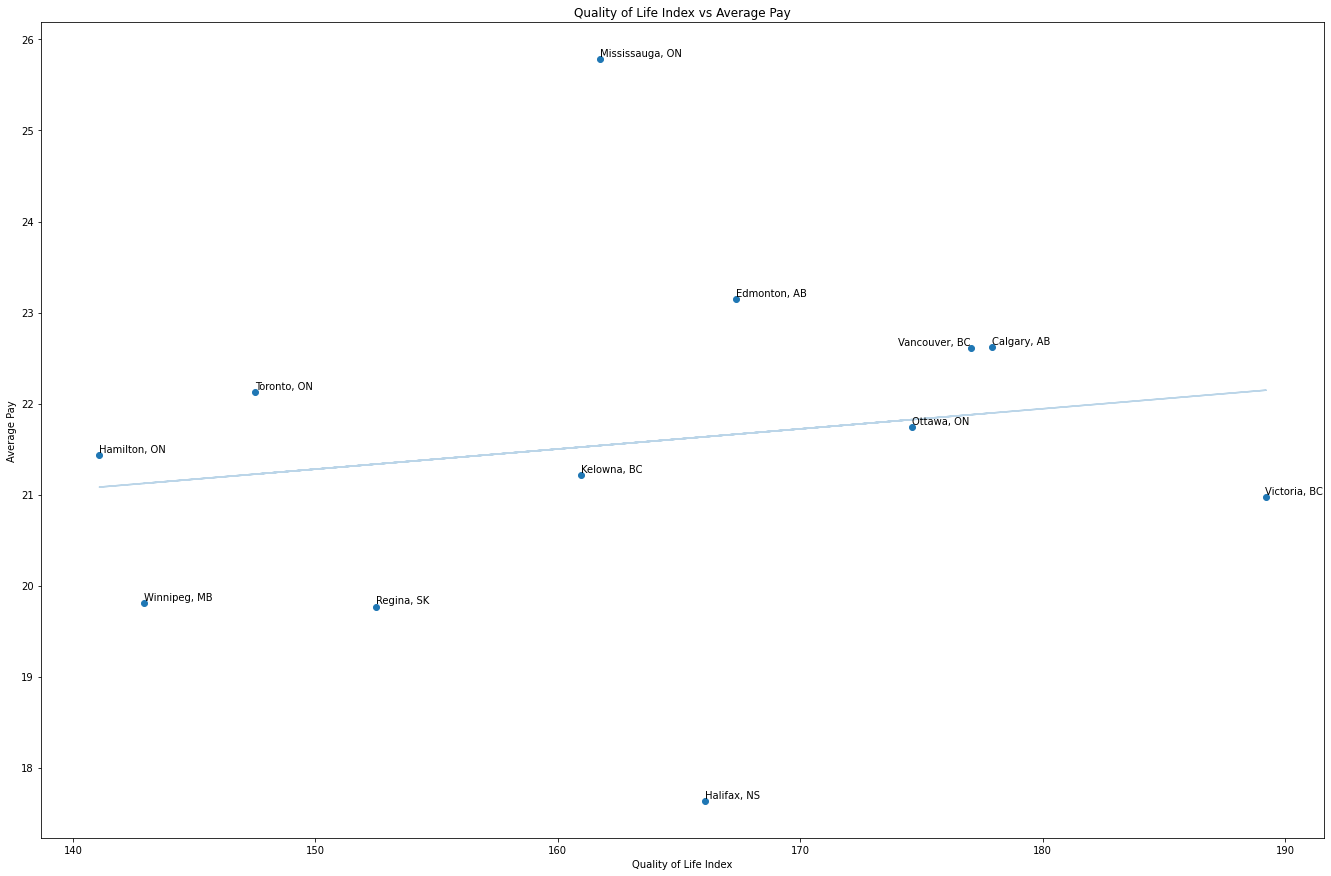

In [33]:
ax = graphScatter('Quality of Life Index',  dependent_column, f"Quality of Life Index vs {dependent_column}",  qol_answer_dataframe)
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
      ax = graphScatter(change['new'],  dependent_column, f"{change['new']} vs {dependent_column}",  qol_answer_dataframe)

w = widgets.Dropdown(
    options=['Quality of Life Index',
       'Purchasing Power Index', 'Safety Index', 'Health Care Index',
       'Cost of Living Index', 'Property Price to Income Ratio',
       'Traffic Commute Time Index', 'Pollution Index', 'Climate Index'],
    value='Quality of Life Index',
    disabled=False,
)

w.observe(on_dropdown_change)

display(w)

**How is the traffic index related to the average hiring salary?**


In [34]:
numbeo_key = "Traffic"
traffic_merged = pd.merge(jobs_noc_merged.copy(deep=True), numbeo[numbeo_key], on="City", how="inner")

#Only consider jobs where the job's pay is stated in hours
traffic_merged = traffic_merged[traffic_merged["PayUnit"] == "HOUR"]

#Compute the average pay for each city and store it inside the city_pay map
city_pay = {"City":[], "Average Pay":[]}
for city, group in traffic_merged.groupby("City"):
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["AveragePay"].mean())
city_pay = pd.DataFrame(city_pay)

#Join the city_pay dictionary with the numbeo traffic dataset
traffic_answer_dataframe = pd.merge(city_pay, numbeo[numbeo_key], on="City", how="inner")

independent_column = "Traffic Index"
dependent_column = "Average Pay"

#Correlation
method = "spearman"
traffic_answer_dataframe.corr(method=method)

,Average Pay,Traffic Index,Time Index(in minutes),Time Exp. Index,Inefficiency Index,CO2 Emission Index
Average Pay,1.000000,0.622378,0.440559,0.440559,0.517483,0.727273
Traffic Index,0.622378,1.000000,0.909091,0.909091,0.741259,0.846154
Time Index(in minutes),0.440559,0.909091,1.000000,1.000000,0.629371,0.622378
Time Exp. Index,0.440559,0.909091,1.000000,1.000000,0.629371,0.622378
Inefficiency Index,0.517483,0.741259,0.629371,0.629371,1.000000,0.594406
CO2 Emission Index,0.727273,0.846154,0.622378,0.622378,0.594406,1.000000


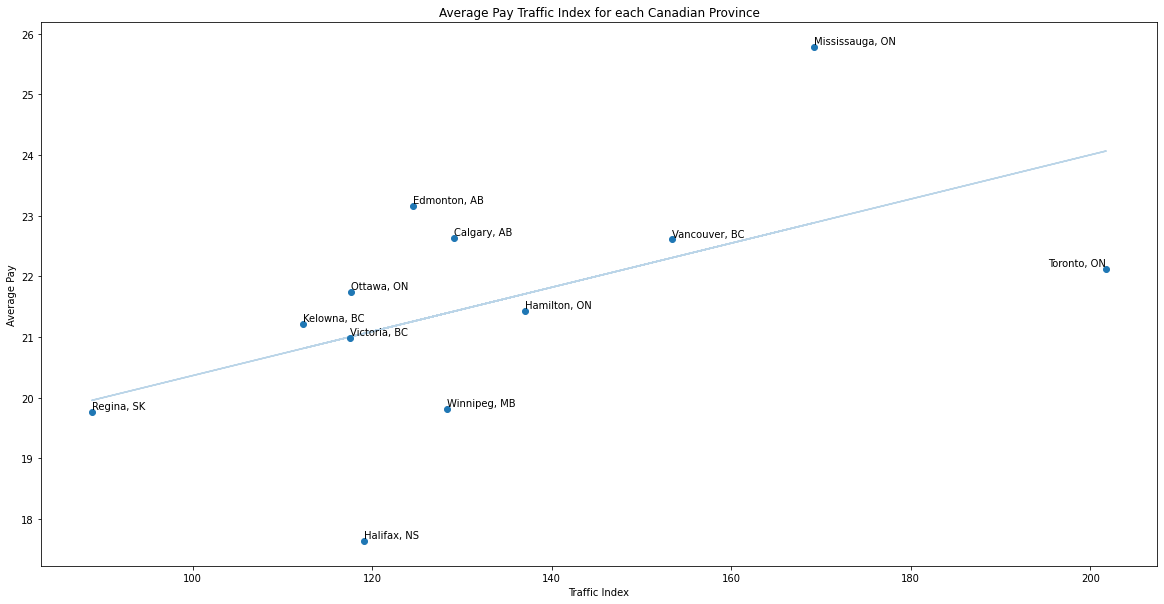

In [35]:
#Visualize
graphScatter(independent_column,  dependent_column, "Average Pay Traffic Index for each Canadian Province", traffic_answer_dataframe, figsize=(20, 10))

**Interactive visualization for traffic data**

Dropdown(options=('Traffic Index', 'Time Index(in minutes)', 'Time Exp. Index', 'Inefficiency Index', 'CO2 Emi…

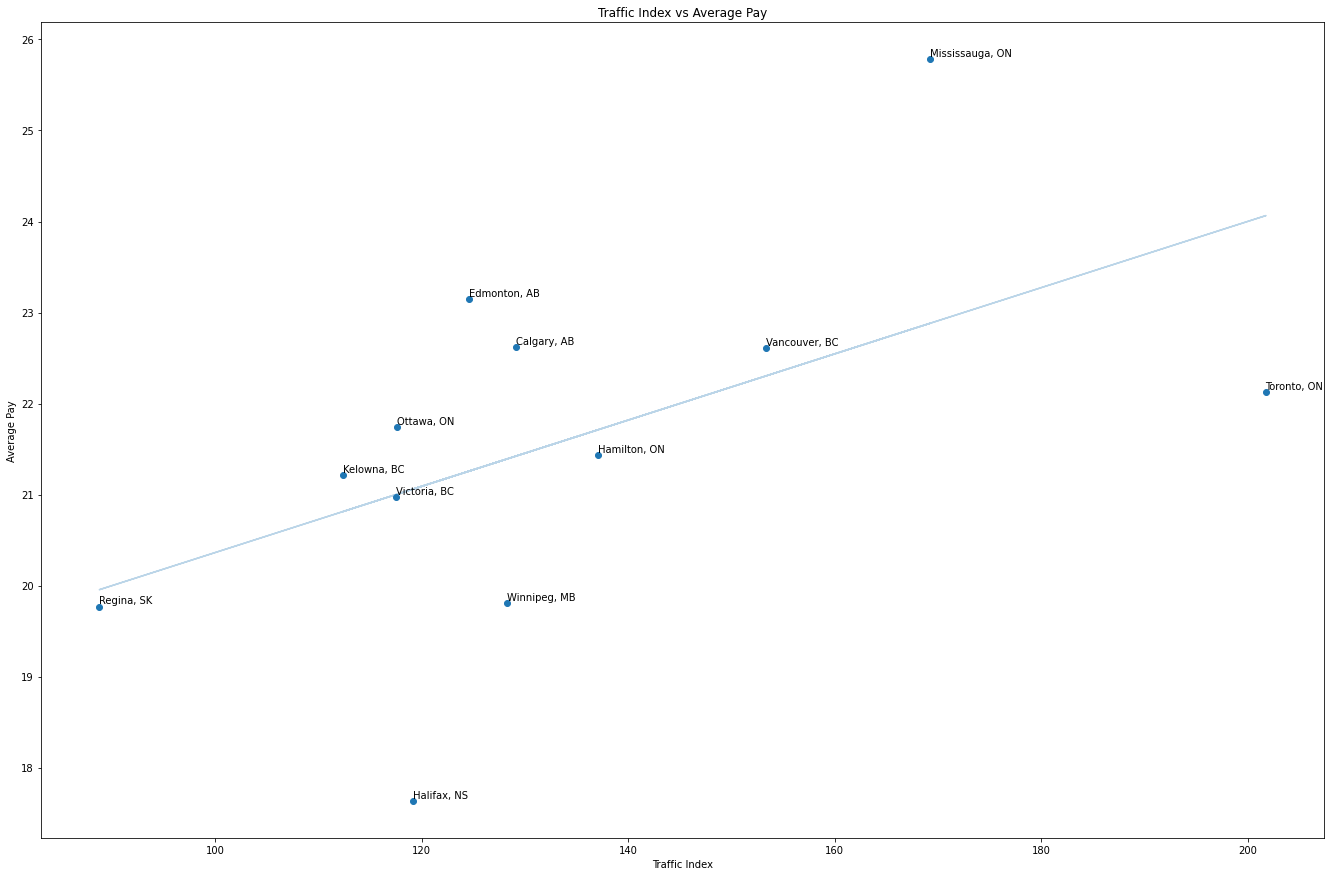

In [36]:
ax = graphScatter('Traffic Index',  dependent_column, f"Traffic Index vs {dependent_column}",  traffic_answer_dataframe)
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
      ax = graphScatter(change['new'],  dependent_column, f"{change['new']} vs {dependent_column}",  traffic_answer_dataframe)

w = widgets.Dropdown(
    options=['Traffic Index', 'Time Index(in minutes)',
       'Time Exp. Index', 'Inefficiency Index', 'CO2 Emission Index'],
    value='Traffic Index',
    disabled=False,
)

w.observe(on_dropdown_change)

display(w)

In [37]:
numbeo.keys()

dict_keys(['CostofLiving', 'Crime', 'HealthCare', 'PropertyPrices', 'Quality of Life', 'Traffic'])

**How is the cost of living index related to the average hiring salary?**

In [38]:
numbeo_key = "CostofLiving"
col_merged = pd.merge(jobs_noc_merged.copy(deep=True), numbeo[numbeo_key], on="City", how="inner")

#Only consider jobs where the job's pay is stated in hours
col_merged = col_merged[col_merged["PayUnit"] == "HOUR"]

#Compute the average pay for each city and store it inside the city_pay map
city_pay = {"City":[], "Average Pay":[]}
for city, group in col_merged.groupby("City"):
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["AveragePay"].mean())
city_pay = pd.DataFrame(city_pay)

#Join the city_pay dictionary with the numbeo traffic dataset
col_answer_dataframe = pd.merge(city_pay, numbeo[numbeo_key], on="City", how="inner")

independent_column = "Cost of Living Plus Rent Index"
dependent_column = "Average Pay"

#Correlation
method = "spearman"
col_answer_dataframe.corr(method=method)

,Average Pay,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
Average Pay,1.000000,0.092650,0.499487,0.563515,-0.069402,-0.042051,0.104957
Cost of Living Index,0.092650,1.000000,0.159658,0.408275,0.878291,0.312137,-0.005812
Rent Index,0.499487,0.159658,1.000000,0.940332,0.097436,0.059145,-0.115897
Cost of Living Plus Rent Index,0.563515,0.408275,0.940332,1.000000,0.297829,0.167208,-0.066336
Groceries Index,-0.069402,0.878291,0.097436,0.297829,1.000000,0.035897,-0.052991
Restaurant Price Index,-0.042051,0.312137,0.059145,0.167208,0.035897,1.000000,0.063932
Local Purchasing Power Index,0.104957,-0.005812,-0.115897,-0.066336,-0.052991,0.063932,1.000000


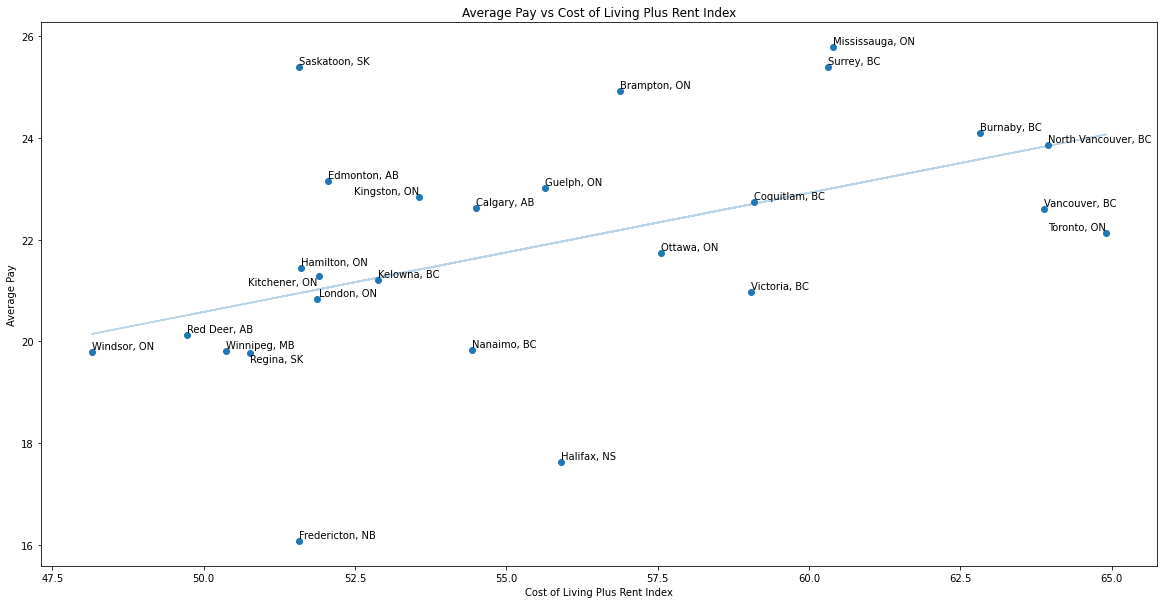

In [39]:
graphScatter(independent_column,  dependent_column, f"{dependent_column} vs {independent_column}", col_answer_dataframe, figsize=(20, 10))

**Interactive Visualization for Cost of Living**

Dropdown(index=2, options=('Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries …

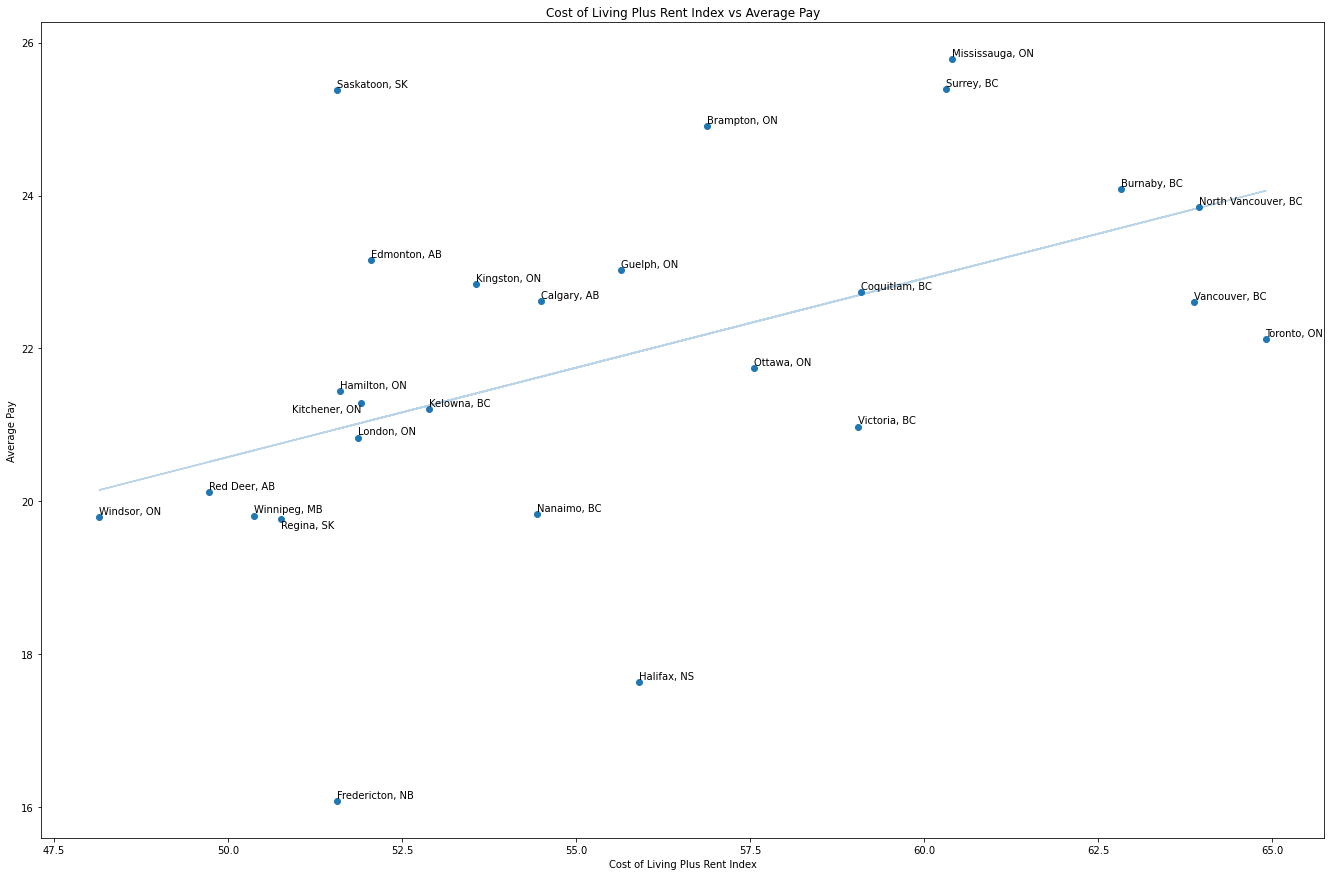

In [40]:
ax = graphScatter('Cost of Living Plus Rent Index',  dependent_column, f"Cost of Living Plus Rent Index vs {dependent_column}",  col_answer_dataframe)
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
      ax = graphScatter(change['new'],  dependent_column, f"{change['new']} vs {dependent_column}",  col_answer_dataframe)

w = widgets.Dropdown(
    options=['Cost of Living Index', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index'],
    value='Cost of Living Plus Rent Index',
    disabled=False,
)

w.observe(on_dropdown_change)

display(w)


**How are Job Levels related to average salary?**

In [41]:
jobs_noc_merged.groupby("JobLevel")["AveragePay"].mean()

JobLevel
 0    34.075003
 A    34.109285
 B    22.693768
 C    17.796669
 D    17.452860
Name: AveragePay, dtype: float64

According to the data, yes there is a correlation between high paying jovs and high skill jobs. 
As shown, the higher the skill level of a job, the higher the pay. 

**Are most jobs on the Job board low skill or high skill jobs?**

In [42]:
jobs_noc_merged["JobLevel"].value_counts()

 B    18132
 C    10658
 D     4852
 0     1860
 A     1447
Name: JobLevel, dtype: int64

**What cities are best with regards to hourly wage for an IT professional (Software Developer, Programmer, etc.)?**

Text(0, 0.5, 'Hourly Wage (CAD)')

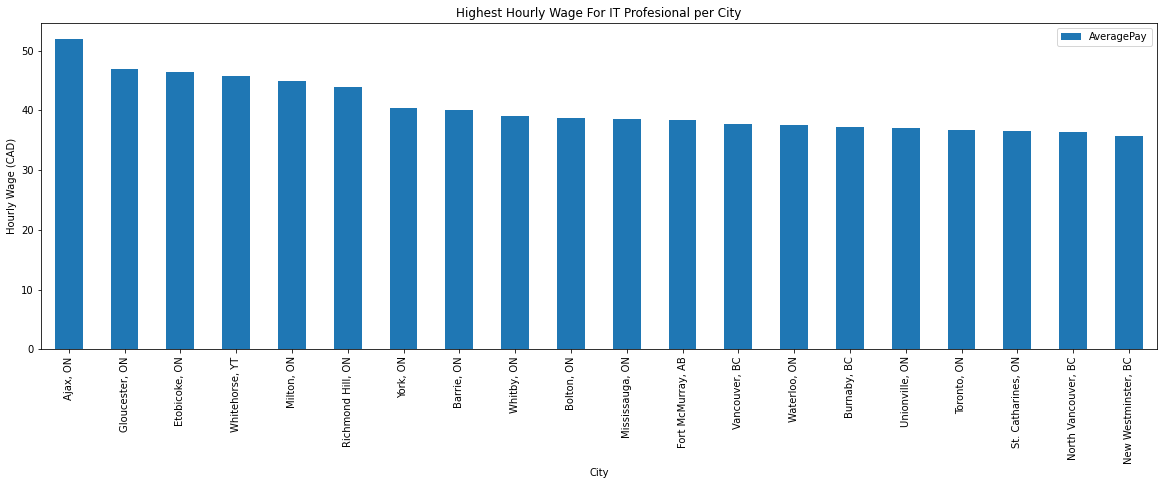

In [43]:
val = jobs_noc_merged["Job Title"].str.lower().str.contains("|".join(["software", "computer", "information", "web", "data"]))

selected = jobs_noc_merged[val].copy(deep=True)
selected = selected[selected["AveragePay"]<80]

selected = selected.groupby("City", as_index=False).mean()
selected = selected.sort_values("AveragePay", ascending=False)

selected_plot = selected.head(20)
ax = selected_plot.plot.bar(x='City', y='AveragePay', figsize=(20,6), title="Highest Hourly Wage For IT Profesional per City") 
ax.set_ylabel("Hourly Wage (CAD)")




**Word Map for visualizing the most common qualifications and skills**


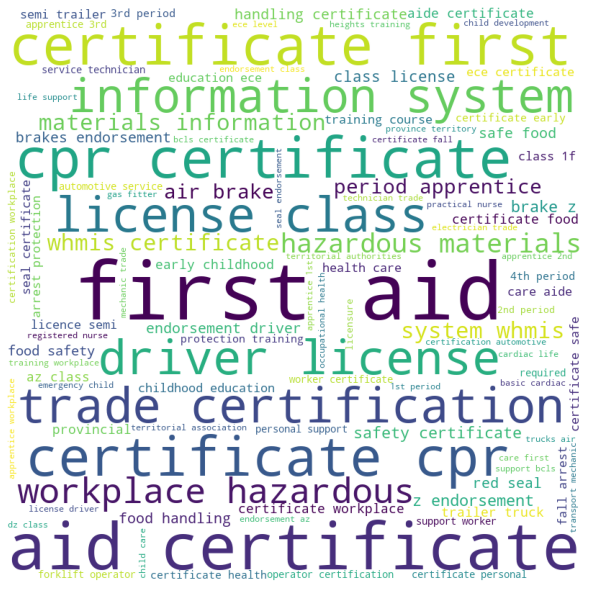

In [44]:
df = jobs_noc_merged.copy(deep=True)

def generateWordCloud(category):
  comment_words = ''
  stopwords = set(STOPWORDS)
  category = category.str.strip()

  for val in category:
      
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "


  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image                       
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

generateWordCloud(df[~df["Qualifications"].isnull()]["Qualifications"])


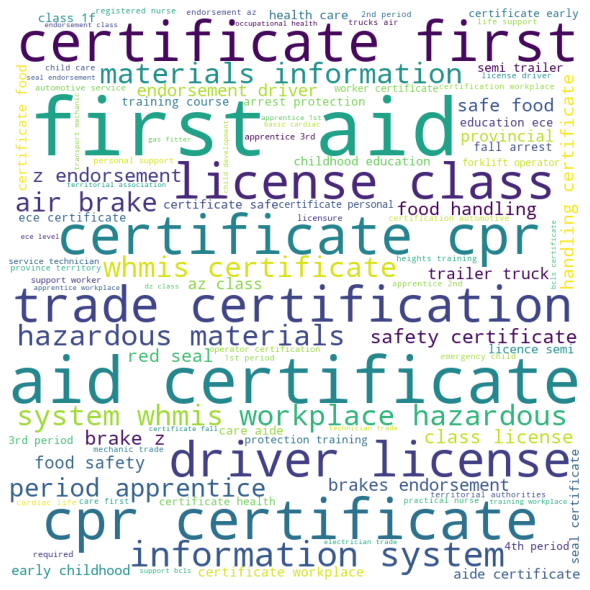

In [45]:
generateWordCloud(df[~df["Qualifications"].isnull()]["Qualifications"])

**Interactive Word Map generator**

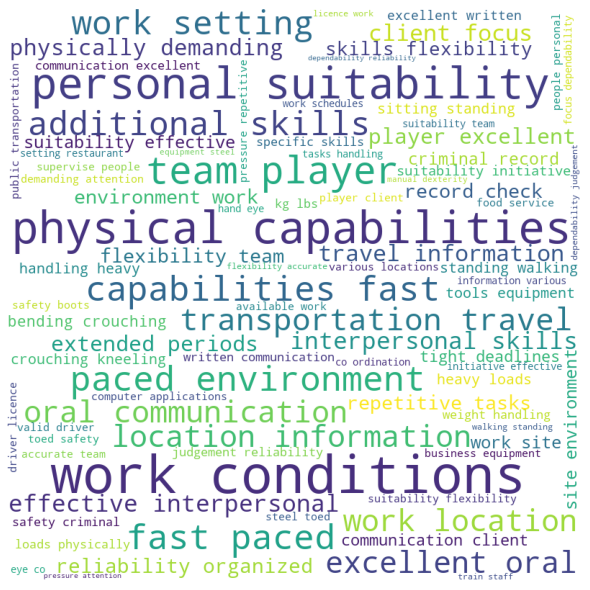

Dropdown(options=('Skills', 'Qualifications', 'Job Title', 'EmploymentTerms', 'HiringOrg', 'JobSource'), value…

In [46]:
df = jobs_noc_merged.copy(deep=True)
generateWordCloud(df[~df["Skills"].isnull()]["Skills"])
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
      generateWordCloud(df[~df[change['new']].isnull()][change['new']])

w = widgets.Dropdown(
    options=['Skills',
       'Qualifications',
       'Job Title',
       'EmploymentTerms',
       'HiringOrg',
       'JobSource'],
    value='Skills',
    disabled=False,
)

w.observe(on_dropdown_change)

display(w)